In [84]:
# https://towardsdatascience.com/causal-inference-with-synthetic-control-in-python-4a79ee636325
# https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html

Our example will consider the problem of estimating the effect of cigarette taxation on its consumption.
One side of the argument says that taxes will increase the cost of cigars, which will lower its demand. The other side argues that since cigarettes cause addiction, change in their price won’t change their demand by much. In economic terms, we would say that the demand for cigarettes is inelastic on price, and an increase in taxation is just a way to increase government income at the cost of smokers. To settle things, we will look at some US data regarding the matter.

In [85]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn import linear_model

%matplotlib inline

cig = (pd.read_csv("smoking_data.csv")
         .drop(columns=["lnincome","beer", "age15to24"]))


In [86]:
# original dataset
cig.head(2)

,state,year,cigsale,retprice
0,Rhode Island,1970,123.900002,39.299999
1,Tennessee,1970,99.800003,39.900002


In [87]:
cig['california'] = (cig['state'] == 'California')
cig['state'], unique_states = pd.factorize(cig.state)
cig['after_treatment'] = (cig.year >= 1988)
cig.head(2)

,state,year,cigsale,retprice,california,after_treatment
0,0,1970,123.900002,39.299999,False,False
1,1,1970,99.800003,39.900002,False,False


In [88]:
unique_states

Index(['Rhode Island', 'Tennessee', 'Indiana', 'Nevada', 'Louisiana',
       'Oklahoma', 'New Hampshire', 'North Dakota', 'Arkansas', 'Virginia',
       'Illinois', 'South Dakota', 'Utah', 'Georgia', 'Mississippi',
       'Colorado', 'Minnesota', 'California', 'Texas', 'Kentucky', 'Maine',
       'North Carolina', 'Montana', 'Vermont', 'Iowa', 'Connecticut', 'Kansas',
       'Delaware', 'Wisconsin', 'Idaho', 'New Mexico', 'West Virginia',
       'Pennsylvania', 'South Carolina', 'Ohio', 'Nebraska', 'Missouri',
       'Alabama', 'Wyoming'],
      dtype='object')

In [89]:
cig.query("california").head()

,state,year,cigsale,retprice,california,after_treatment
17,17,1970,123.000000,38.799999,True,False
68,17,1971,121.000000,39.700001,True,False
96,17,1972,123.500000,39.900002,True,False
150,17,1973,124.400002,39.900002,True,False
164,17,1974,126.699997,41.900002,True,False


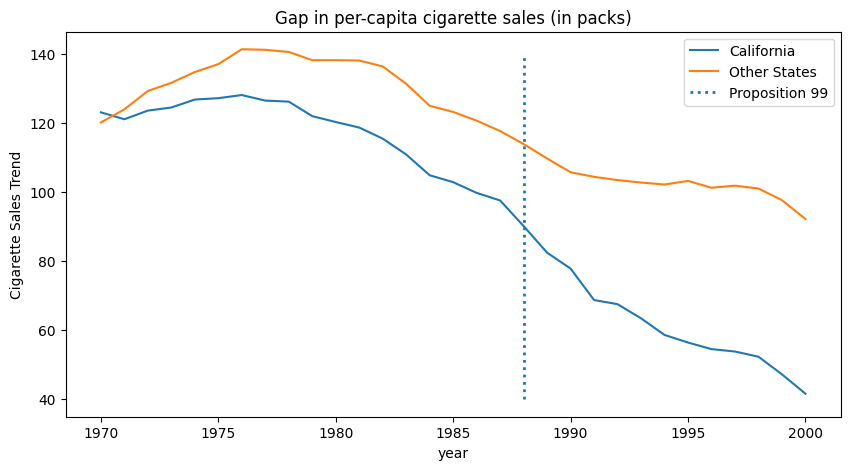

In [90]:
ax = plt.subplot(1, 1, 1)
(cig
 .assign(california = np.where(cig["california"], "California", "Other States"))
 .groupby(["year", "california"])
 ["cigsale"]
 .mean()
 .reset_index()
 .pivot(index="year", columns="california", values="cigsale")
 .plot(ax=ax, figsize=(10,5)))

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Cigarette Sales Trend")
plt.title("Gap in per-capita cigarette sales (in packs)")
plt.legend()
plt.show()

To answer the question of whether Proposition 99 had an effect on cigarette consumption, we will use the pre-intervention period to build a synthetic control. We will combine the other states to build a fake state that resembles very closely the trend of California. Then, we will see how this synthetic control behaves after the intervention.

In [91]:
cig.head(10)

,state,year,cigsale,retprice,california,after_treatment
0,0,1970,123.900002,39.299999,False,False
1,1,1970,99.800003,39.900002,False,False
2,2,1970,134.600006,30.600000,False,False
3,3,1970,189.500000,38.900002,False,False
4,4,1970,115.900002,34.299999,False,False
5,5,1970,108.400002,38.400002,False,False
6,6,1970,265.700012,31.400000,False,False
7,7,1970,93.800003,37.299999,False,False
8,8,1970,100.300003,36.700001,False,False
9,9,1970,124.300003,28.799999,False,False


In [92]:

features = ["cigsale", "retprice"]

inverted = (cig.query("~after_treatment") # filter pre-intervention period
            .pivot(index='state', columns="year")[features] # make one column per year and one row per state
            .T) # flip the table to have one column per state

inverted.head()

state                 0           1           2           3           4   \
        year                                                               
cigsale 1970  123.900002   99.800003  134.600006  189.500000  115.900002   
        1971  123.199997  106.300003  139.300003  190.500000  119.800003   
        1972  134.399994  111.500000  149.199997  198.600006  125.300003   
        1973  142.000000  109.699997  156.000000  201.500000  126.699997   
        1974  146.100006  114.800003  159.600006  204.699997  129.899994   

state                 5           6           7           8           9   ...  \
        year                                                              ...   
cigsale 1970  108.400002  265.700012   93.800003  100.300003  124.300003  ...   
        1971  115.400002  278.000000   98.500000  104.099998  128.399994  ...   
        1972  121.699997  296.200012  103.800003  103.900002  137.000000  ...   
        1973  124.099998  279.000000  108.699997  108.000000  143.100006  ...   
        1974  130.500000  269.799988  110.500000  109.699997  149.600006  ...   

state                 29          30          31          32          33  \
        year                                                               
cigsale 1970  102.400002   90.000000  114.500000  107.300003  103.599998   
        1971  108.500000   92.599998  111.500000  106.300003  115.000000   
        1972  126.099998   99.300003  117.500000  109.000000  118.699997   
        1973  121.800003   98.900002  116.599998  110.699997  125.500000   
        1974  125.599998  100.300003  119.900002  114.199997  129.699997   

state                 34          35          36          37          38  
        year                                                              
cigsale 1970  121.599998  108.099998  121.300003   89.800003  132.199997  
        1971  124.599998  108.599998  127.599998   95.400002  131.699997  
        1972  124.400002  104.900002  130.000000  101.099998  140.000000  
        1973  120.500000  106.599998  132.100006  102.900002  141.199997  
        1974  122.099998  110.500000  135.399994  108.199997  145.800003  

[5 rows x 39 columns]

In [93]:
y = inverted[17].values # state of california
X = inverted.drop(columns=17).values  # other states

Other states becomes our predictor for each years cigsale value of California
meaning that Y1970 = California cig sale 1970
and a w1*Y1970_state1, wJ*Y1970_stateJ, other states
and we run a regularized regression because we do not want overfitting. We minimise error 
over all weighted J control states when compared to California cig sale.

In [115]:
from sklearn.linear_model import Lasso, LinearRegression
weights_lr = Lasso(fit_intercept=False, alpha =  1).fit(X, y).coef_
weights_linear = LinearRegression(fit_intercept=False).fit(X, y).coef_
print(weights_linear.round(3))
weights_lr.round(3)


[ 0.048  0.394 -0.298  0.187 -1.08  -0.051 -0.032  0.874 -0.648 -0.596
  0.332  0.165  0.083  0.983 -0.149  0.613  0.083  0.13   0.473  0.483
 -0.143 -0.134 -0.229  0.259  0.058 -0.255  0.131  0.219  0.065 -0.322
  0.979 -0.383 -0.372  0.034 -0.585 -0.368 -0.103  0.064]


C:\Users\Wade\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.030e+02, tolerance: 3.338e+01
  model = cd_fast.enet_coordinate_descent(


array([ 0.484,  0.2  ,  0.041,  0.148, -0.042,  0.021,  0.073,  0.   ,
       -0.156, -0.059,  0.029,  0.047,  0.145, -0.068, -0.071,  0.   ,
        0.118,  0.029, -0.118, -0.   , -0.006,  0.169, -0.016, -0.   ,
        0.102, -0.12 , -0.   , -0.   ,  0.   ,  0.031,  0.123, -0.   ,
       -0.158, -0.   , -0.   , -0.089,  0.   ,  0.069])

In [116]:
calif_synth_lr = (cig.query("~california")
                  .pivot(index='year', columns="state")["cigsale"]
                  .values.dot(weights_lr))

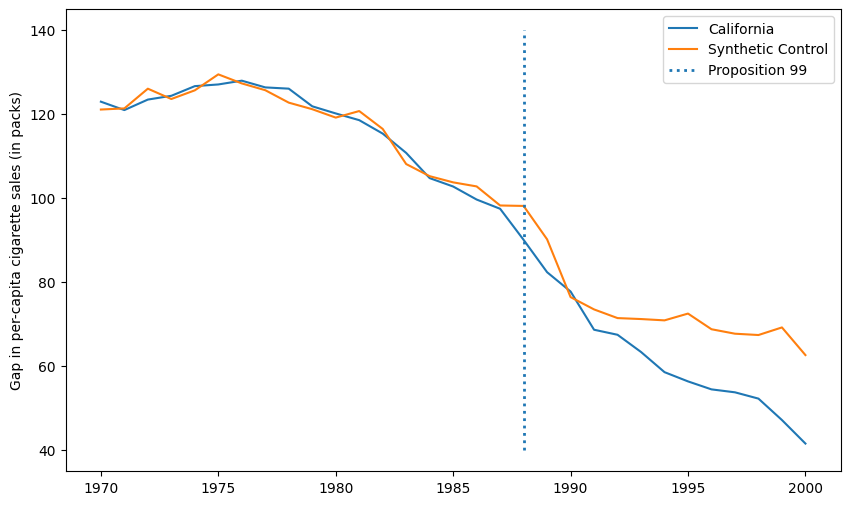

In [117]:
plt.figure(figsize=(10,6))
plt.plot(cig.query("california")["year"], cig.query("california")["cigsale"], label="California")
plt.plot(cig.query("california")["year"], calif_synth_lr, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend()

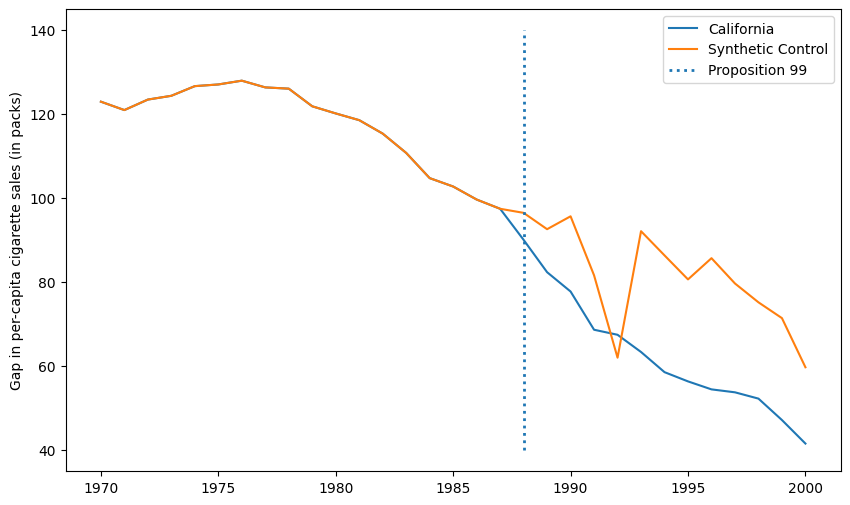

In [118]:
calif_synth_linear = (cig.query("~california")
                  .pivot(index='year', columns="state")["cigsale"]
                  .values.dot(weights_linear))
plt.figure(figsize=(10,6))
plt.plot(cig.query("california")["year"], cig.query("california")["cigsale"], label="California")
plt.plot(cig.query("california")["year"], calif_synth_linear, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend()

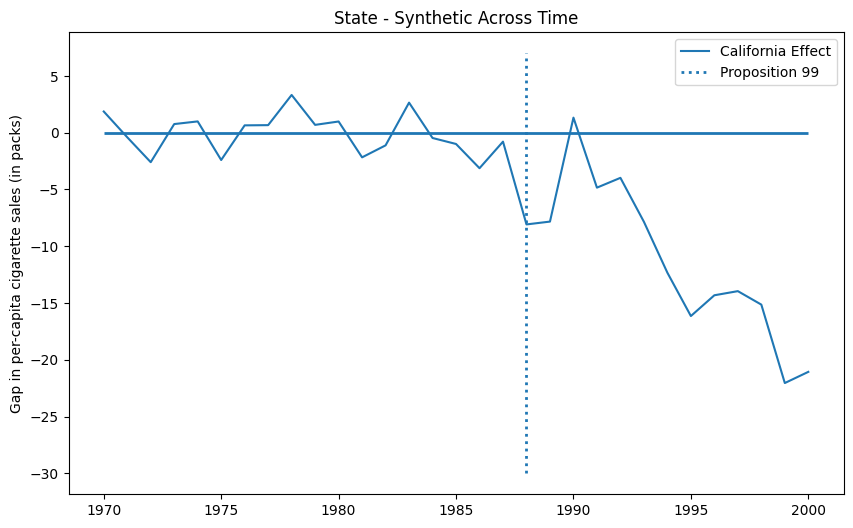

In [119]:
plt.figure(figsize=(10,6))
plt.plot(cig.query("california")["year"], cig.query("california")["cigsale"] - calif_synth_lr,
         label="California Effect")
plt.vlines(x=1988, ymin=-30, ymax=7, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=2)
plt.title("State - Synthetic Across Time")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend()